#### Classification | Model

# Predicting Heart Disease  

## Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
4. [Baselining](#4)<br/>
5. [Validation and Testing](#5)<br/>
6. [Model Iterations](#6) <br/>
7. [Model Selection ](#7)<br/>



In [1]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ipywidgets import interactive, FloatSlider
from plotly.subplots import make_subplots
from sklearn.compose import make_column_transformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier


## 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c)

### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

## 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [2]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [3]:
# clean df
heart_disease_df.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,Yes,No,5.0,Yes,55-59,Female,White,Yes,Yes,No,Yes,No,16.60,Very good,30.0,No,3.0,No
1,Yes,No,7.0,No,80 or older,Female,White,No,No,No,No,Yes,20.34,Very good,0.0,No,0.0,No
2,Yes,No,8.0,Yes,65-69,Male,White,Yes,Yes,No,No,No,26.58,Fair,30.0,No,20.0,No


In [4]:
# mapped categorical variables to numberical values 
heart_disease_df_map.head(3)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


## 3 | Exporatory Data Analysis<a id='3'></a> 

**3a. Look at, summarize, and clean the data.**<a id='3a'></a> 

In [5]:
# EDA and model with the mapped df
heart_disease_df_map.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

**3b. Scope out classification viability.**<a id='3b'></a> 

In [22]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


,count,mean,std,min,25%,50%,75%,max
behavior_activity,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,319795.000000,52.440945,18.069747,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,319795.000000,1.475273,0.499389,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,319795.000000,5.396742,1.212208,1.000000,6.000000,6.000000,6.000000,6.000000
disease_asthma,319795.000000,0.134061,0.340718,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,319795.000000,0.207205,0.554528,0.000000,0.000000,0.000000,0.000000,3.000000
disease_kidney,319795.000000,0.036833,0.188352,0.000000,0.000000,0.000000,0.000000,1.000000


In [18]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197


[back to top](#top)

In [ ]:
## target vs. features 
# sns.pairplot(heart_disease_df_map, hue='y_heart_disease');

##not running

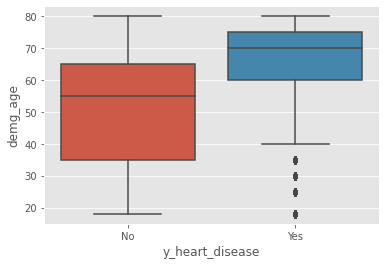

In [31]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


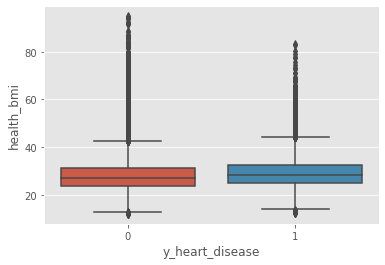

In [32]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


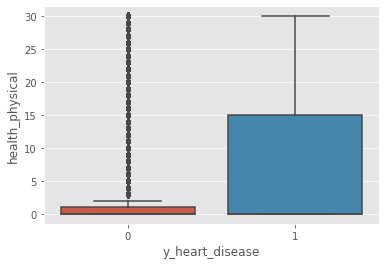

In [33]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [40]:
# target distribution
print('Target Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


Target Ratio: 9.36 %
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64


**3c. Determine classification metric(s).**<a id='3c'></a> 

To maximize on the model capturing the patients who are true positives for heart disease, will the errror metric recall. 

To identify high vs low risk patients, will use ROC AUC. 

[back to top](#top)

## 4 | Baseline<a id='4'></a> 

**4a. Build a simple baseline model with a handful of features.**

In [53]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 

X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

In [54]:
# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, 
                                                    y_base, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_base, X_validate_base, y_train_base, y_validate_base = train_test_split(X_train_base, y_train_base, 
                                                            test_size = .25, random_state = 42)


In [55]:
# scale baseline X train/test
scaler_base = StandardScaler()
X_train_scaled_base = scaler_base.fit_transform(X_train_base)
X_test_scaled_base = scaler_base.transform(X_test_base)
X_validate_scaled_base = scaler_base.transform(X_validate_base)


In [56]:
# baseline logistic regression X train scaled & y train
logreg_base = LogisticRegression().fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = logreg_base.predict(X_validate_scaled_base) 


In [58]:
# score on X_test_scaled and y_test
print("Baseline logistic regression recall:", round(recall_score(logreg_map.predict(X_test_scaled_m), y_test_m), 4))


Baseline logistic regression recall: 0.3634


[back to top](#top)

## 5. Validation and Testing<a id='5'></a>

- Cross-validation will often be preferable to simple, single-set validation due to its robustness. 
- Using your chosen validation scheme, you can perform iterative feature selection/expansion/engineering and model complexity adjustments in order to complete the next 2 steps. 
- You will use the test data only once your model is finalized in order to compute a final estimate of generalization performance.



In [ ]:
# validate set from above: X_validate_base, y_validate_base


In [73]:
# classification report on y_validate/predict
print(classification_report(y_validate_base, y_pred_base, target_names=['no heart disease', 'yes heart disease']))



                   precision    recall  f1-score   support

 no heart disease       0.92      1.00      0.95     58473
yes heart disease       0.36      0.02      0.04      5486

         accuracy                           0.91     63959
        macro avg       0.64      0.51      0.50     63959
     weighted avg       0.87      0.91      0.88     63959



[back to top](#top)

## 6. Model Iterations <a id='6'></a> 

- Starting from the baseline and in an iterative, validated loop ask: 
    - Do you need more complexity or less (underfitting vs. overfitting)? 
    - Do you need a fancier model (nonlinear, additional feature engineering / transformations)? 
    - If you need more complexity, try tree-based models such as random forest or gradient boosted trees. 
    - Are you overfitting and need to make your model more conservative by removing features or using regularization? - Hopefully you can quickly acquire an understanding of which direction you need to go in from your baseline and early modeling results, then make more fine-tuned changes as you go.


- The impact of model choices should be consistently measured against the same validation data as in part 3, using your relevant classification performance metrics such as F1 or ROC AUC. 


In [75]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 

X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

In [129]:
# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                            test_size = .25, random_state = 42)


In [77]:
# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validate_scaled = scaler.transform(X_validate)


#### k-Nearest Neighbors<a id='6a'></a> 

In [86]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train_scaled, y_train)
y_pred_knn = knn.predict_proba(X_test_scaled)
print('KNN recall:', round(recall_score(knn.predict(X_test_scaled), y_test), 4))

# not running

* KNN ...

[back to top](#top)

#### Logistic Regression<a id='6b'></a> 

In [126]:
log_reg = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_lg = log_reg.predict(X_validate_scaled) 
print("Logistic regression recall:", round(recall_score(log_reg.predict(X_test_scaled), y_test), 4))


Logistic regression recall: 0.5327


Logistic regression improved from [baseline](#4).

[back to top](#top)

#### Random Forests<a id='6c'></a> 

In [91]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = forest.predict(X_validate)
print("Random forestes recall:", round(recall_score(forest.predict(X_test), y_test), 4))


Random forestes recall: 0.3633


Random forest model performs worse than [logistic regression](#6b) (0.5327). 

[back to top](#top)

#### Gradient Boosted Trees<a id='6d'></a> 

In [ ]:
### code block

[back to top](#top)

#### Ensembling<a id='6e'></a> 

In [ ]:
### code block

[back to top](#top)

#### Naive Bayes<a id='6f'></a> 

In [ ]:
### code block

[back to top](#top)

## Class Imblance Handling <a id='6g'></a> 

In [98]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

In [135]:
# resample?

In [134]:
# class_weight adjustments

In [ ]:
# decision threshold to max recall

[back to top](#top)

[back to top](#top)

## Feature Engineering <a id='6h'></a> 

Create features based on four groups in [data dictionary](#1a): behaviors, demographics, disease, and health measures. 

In [130]:
# 1 behaviors = phyiscial activity days/month, sleep time hrs/day,  alcohol, and tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age, gender, race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma, diabetes, kidney, skin cancer, stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 health (measures) = asthma, diabetes, kidney, skin cancer, stroke
heart_disease_df_map['health'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.head(2)


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,...,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease,behaviors,demographics,disease,health
0,1,0,5.0,1,55,1,6,1,1,0,...,16.60,4,30.0,0,3.0,0,7.0,62,3,53.60
1,1,0,7.0,0,80,1,6,0,0,0,...,20.34,4,0.0,0,0.0,0,8.0,87,1,24.34


### Logistic regression, only engineered features<a id='6h1'></a> 

In [120]:
# Separate target from engineered features 
y_f = heart_disease_df_map['y_heart_disease'] 

X_f = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'health']]

In [121]:
# Split data test/train/validate
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, 
                                                    y_f, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_f, X_validate_f, y_train_f, y_validate_f = train_test_split(X_train_f, y_train_f, 
                                                            test_size = .25, random_state = 42)
# Scale X train/test/validate
scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)
X_validate_f_scaled = scaler.transform(X_validate_f)


In [122]:
# Logistic regression with feature eng
log_reg_f = LogisticRegression().fit(X_train_f_scaled, y_train_f)
y_pred_f = log_reg_f.predict(X_validate_f_scaled) 
print("Logistic regression recall:", round(recall_score(log_reg_f.predict(X_test_f_scaled), y_test_f), 4))


Logistic regression recall: 0.4731


Logistic regression with only engineered features performs worse than first iteration of [logistic regression](#6b). 

### Logistic regression, original + engineered features<a id='6h2'></a> 

In [131]:
# Separate target from features 
y_ff = heart_disease_df_map['y_heart_disease'] 

X_ff = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'health',
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

In [132]:
# Split data test/train/validate
X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, 
                                                    y_ff, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_ff, X_validate_ff, y_train_ff, y_validate_ff = train_test_split(X_train_ff, y_train_ff, 
                                                            test_size = .25, random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_ff_scaled = scaler.fit_transform(X_train_ff)
X_test_ff_scaled = scaler.transform(X_test_ff)
X_validate_ff_scaled = scaler.transform(X_validate_ff)


In [133]:
# Logistic regression with all features + feat eng
log_reg_ff = LogisticRegression().fit(X_train_ff_scaled, y_train_ff)
y_pred_ff = log_reg_ff.predict(X_validate_ff_scaled) 
print("Logistic regression recall:", round(recall_score(log_reg_ff.predict(X_test_ff_scaled), y_test_ff), 4))


Logistic regression recall: 0.5327


Logistic regression with original + engineered features performs better than [logistic regression model with only engineered features](#6h1) and the same as the first iteration of [logistic regression](#6b). 

[back to top](#top)

## 7. Model Selection<a id='7'></a> 

**7a. Finalize and test.** 
- When satisfied with the results of your tuning in _Model Iterations_, establish your final model choices:
        - features, 
        - preprocessing, 
        - imbalance handling strategy, and 
        - hyperparameters
    - retrain this model on all training + validation data. 
- Make predictions on the test data and score these predictions, reporting this score as your estimate of the model's generalization performance.

In [49]:
# Test data from above: X_test_m, y_test_m

In [95]:
# Confusion matrix on y_validate, y_pred_lg
print("[model] confusion matrix: \n\n", confusion_matrix(y_validate, y_pred_lg))

[model] confusion matrix: 

 [[57968   505]
 [ 4940   546]]


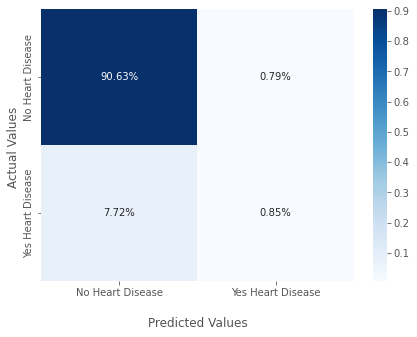

In [96]:
# Confusion matrix on y_validate, y_pred_lg
cm = confusion_matrix(y_validate, y_pred_lg)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No Heart Disease','Yes Heart Disease'])
ax.yaxis.set_ticklabels(['No Heart Disease','Yes Heart Disease'])

plt.show()

**Interpret:** 
- Extract and study your final model coefficients or feature importances. Are there any interesting or unexpected takeaways? 
- How do the model coefficients/importances align with your intuition and domain knowledge about the problem? 
- Be careful about complicating factors in interpretation such as differing feature scales and multicollinearity.


[back to top](#top)